# Импорты

In [131]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_md

In [4]:
from dotenv import load_dotenv
load_dotenv()

False

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import spacy

from collections import defaultdict, Counter
from datasets import load_dataset, concatenate_datasets
from wordcloud import WordCloud
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords
import math

# Если еще не скачаны стоп-слова:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayuschenikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Описание датасета CrossNER

**Источник:** [Статья (PDF)](https://arxiv.org/pdf/2012.04373)

Датасет **CrossNER** разработан для оценки и изучения способности моделей распознавания именованных сущностей (NER) к обобщению между различными доменами. Он содержит данные из шести областей (доменных подсекций), извлечённые из английской Википедии, а также включает классический набор данных CoNLL2003:

- **AI**: Данные о темах, связанных с искусственным интеллектом.
- **Literature**: Тексты о литературных произведениях, писателях, жанрах.
- **Music**: Материалы о музыке, исполнителях, композициях, жанрах.
- **Politics**: Информация о политиках, политических событиях, партиях.
- **Science**: Данные о научных концептах, учёных, открытиях.
- **CoNLL2003**: Классический эталонный датасет для NER для сравнения.

Каждая доменная подсекция содержит свои специфические типы именованных сущностей, что позволяет оценить способность моделей обобщать знания, полученные в одном домене, на другие.

Структура и особенности датасета:
- Доступны три сплита для каждой доменной подсекции: `train`, `validation`, `test`.
- Набор сущностей и их распределение сильно варьируются от домена к домену.
- Датасет был создан для исследования междоменного переноса и устойчивости NER-моделей. В частности: CoNLL2003 рассматривался как source dataset, a остальные 5 доменов, как target dataset.

![image.png](images/1.png)

**Здесь будет изображение с таблицей статистических характеристик датасета (количество предложений, токенов, сущностей для каждого домена)**

Применение:
- Оценка качества и устойчивости моделей NER при переходе между доменами.
- Изучение влияния доменных различий на результаты распознавания сущностей.
- Разработка более универсальных и обобщающих NER-моделей, способных работать в условиях значительных доменных сдвигов.

ВАЖНО! Так как некоторая оценка и исследование проведено в статье оригинального датасета и их легко "сравнить", давайте попробуем сделать так, чтобы представленные методы метчились в оценками, приведенными в статье. У нас не стоит задача превзойти метрики, представленные там, поскольку нам важно не происследовать перенос с одного домена на другой, а обучить модель, способную на всем представленном датасете (общем) получить похожие метрики и необязательно презвойти их (иначе это не тянет на 2х недельную лабу).

ВАЖНО 2: так как наши одногруппники взяли в рассмотрение одиночный датасет **CoNLL2003**, а он содержится в наших данных мы его не будем выкидывать, но основная наша цель - работать и получать метрики по другим (target) датасетам, однако мы на всякий случай решили оставить **CoNLL2003**, на случай, если содержание этого датасета в наших расширенных данных не вызовет проблем.

# EDA

## Загрузка данных

In [30]:
domains = ["ai", "conll2003", "literature", "music", "politics", "science"]

train_datasets = []
val_datasets = []
test_datasets = []

dataset = {}

for subsection in domains:
    ds = load_dataset("DFKI-SLT/cross_ner", subsection)
    # Добавляем колонку "source"
    ds_train = ds["train"].map(lambda x: {"source": subsection})
    ds_val = ds["validation"].map(lambda x: {"source": subsection})
    ds_test = ds["test"].map(lambda x: {"source": subsection})
    
    # Собираем в списки
    train_datasets.append(ds_train)
    val_datasets.append(ds_val)
    test_datasets.append(ds_test)

# Объединяем все в единые датасеты
dataset["train"] = concatenate_datasets(train_datasets)
dataset["val"] = concatenate_datasets(val_datasets)
dataset["test"] = concatenate_datasets(test_datasets)

Теперь у нас есть три датасета: train_dataset, val_dataset, test_dataset.
Каждый пример содержит колонку "source" с указанием исходной подсекции.

In [7]:
dataset["train"]

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'source'],
    num_rows: 14741
})

## Как выглядят данные?

Рассмотрим первый элемент данных, мы видим, что для каждого элемента данных мы имеем:
- индекс конкретного элемента, 
- токены, которые представляют собой каждое отдельно слово
- уже закодированные теги каждого слов
- источник или домен данных, чтобы понимать, из какого датасета данный конкретный пример

In [8]:
import pandas as pd
pd.DataFrame(dataset["train"][0])

,id,tokens,ner_tags,source
0,0,Popular,0,ai
1,0,approaches,0,ai
2,0,of,0,ai
3,0,opinion-based,59,ai
4,0,recommender,60,ai
...,...,...,...,...
59,0,5,0,ai
60,0,),0,ai
61,0,:,0,ai
62,0,e12957,0,ai


## Анализ для тегов

Давайте поближе посмотрим на кодировку:

### Что это?

In [9]:
tag2id = {"O": 0, "B-academicjournal": 1, "I-academicjournal": 2, "B-album": 3, "I-album": 4, "B-algorithm": 5, "I-algorithm": 6, "B-astronomicalobject": 7, "I-astronomicalobject": 8, "B-award": 9, "I-award": 10, "B-band": 11, "I-band": 12, "B-book": 13, "I-book": 14, "B-chemicalcompound": 15, "I-chemicalcompound": 16, "B-chemicalelement": 17, "I-chemicalelement": 18, "B-conference": 19, "I-conference": 20, "B-country": 21, "I-country": 22, "B-discipline": 23, "I-discipline": 24, "B-election": 25, "I-election": 26, "B-enzyme": 27, "I-enzyme": 28, "B-event": 29, "I-event": 30, "B-field": 31, "I-field": 32, "B-literarygenre": 33, "I-literarygenre": 34, "B-location": 35, "I-location": 36, "B-magazine": 37, "I-magazine": 38, "B-metrics": 39, "I-metrics": 40, "B-misc": 41, "I-misc": 42, "B-musicalartist": 43, "I-musicalartist": 44, "B-musicalinstrument": 45, "I-musicalinstrument": 46, "B-musicgenre": 47, "I-musicgenre": 48, "B-organisation": 49, "I-organisation": 50, "B-person": 51, "I-person": 52, "B-poem": 53, "I-poem": 54, "B-politicalparty": 55, "I-politicalparty": 56, "B-politician": 57, "I-politician": 58, "B-product": 59, "I-product": 60, "B-programlang": 61, "I-programlang": 62, "B-protein": 63, "I-protein": 64, "B-researcher": 65, "I-researcher": 66, "B-scientist": 67, "I-scientist": 68, "B-song": 69, "I-song": 70, "B-task": 71, "I-task": 72, "B-theory": 73, "I-theory": 74, "B-university": 75, "I-university": 76, "B-writer": 77, "I-writer": 78}
id2tag = {id: tag for tag, id in tag2id.items()}
id2tag

{0: 'O',
 1: 'B-academicjournal',
 2: 'I-academicjournal',
 3: 'B-album',
 4: 'I-album',
 5: 'B-algorithm',
 6: 'I-algorithm',
 7: 'B-astronomicalobject',
 8: 'I-astronomicalobject',
 9: 'B-award',
 10: 'I-award',
 11: 'B-band',
 12: 'I-band',
 13: 'B-book',
 14: 'I-book',
 15: 'B-chemicalcompound',
 16: 'I-chemicalcompound',
 17: 'B-chemicalelement',
 18: 'I-chemicalelement',
 19: 'B-conference',
 20: 'I-conference',
 21: 'B-country',
 22: 'I-country',
 23: 'B-discipline',
 24: 'I-discipline',
 25: 'B-election',
 26: 'I-election',
 27: 'B-enzyme',
 28: 'I-enzyme',
 29: 'B-event',
 30: 'I-event',
 31: 'B-field',
 32: 'I-field',
 33: 'B-literarygenre',
 34: 'I-literarygenre',
 35: 'B-location',
 36: 'I-location',
 37: 'B-magazine',
 38: 'I-magazine',
 39: 'B-metrics',
 40: 'I-metrics',
 41: 'B-misc',
 42: 'I-misc',
 43: 'B-musicalartist',
 44: 'I-musicalartist',
 45: 'B-musicalinstrument',
 46: 'I-musicalinstrument',
 47: 'B-musicgenre',
 48: 'I-musicgenre',
 49: 'B-organisation',
 50: 

Мы видим, что для каждой сущности, например сущность писатель (writer) есть две метки: начало метки ('B-writer') и то, что еще находится в этой метке ('I-writer'). Метка 'O' предсталяет из себя лейбл для всех неименнованных сущностей, то есть тех сущностей, которые нас не интересуют. Пример:

In [10]:
example = pd.DataFrame(dataset["train"][0])
example["ners"] = example["ner_tags"].apply(lambda x: id2tag[x])
example[["tokens", "ners", "ner_tags"]].head(10)

,tokens,ners,ner_tags
0,Popular,O,0
1,approaches,O,0
2,of,O,0
3,opinion-based,B-product,59
4,recommender,I-product,60
5,system,I-product,60
6,utilize,O,0
7,various,O,0
8,techniques,O,0
9,including,O,0


Таким образом мы понимаем, что `opinion-based recommender system` - это какой-то продукт

### Пересекаются ли лейблы теги между датасетами?

Filter: 100%|██████████| 5959/5959 [00:00<00:00, 21284.10 examples/s]


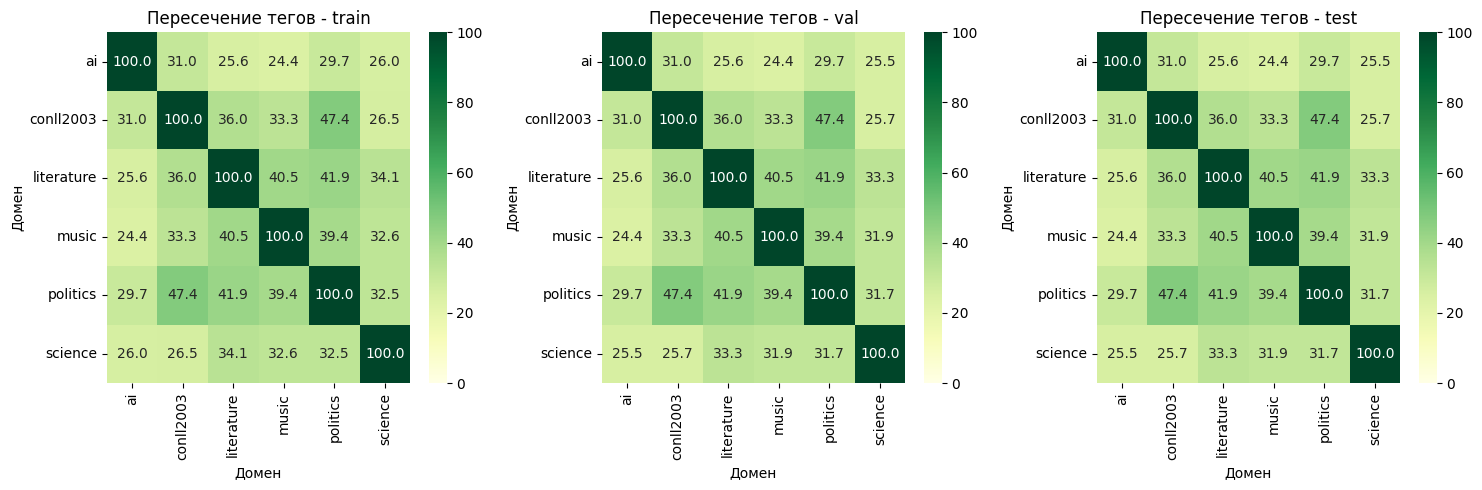

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

domains = ["ai", "conll2003", "literature", "music", "politics", "science"]

def get_domain_tags(dataset, domain_name, with_o=True):
    """
    Извлекает теги для домена.
    """
    domain_examples = dataset.filter(lambda x: x["source"] == domain_name)
    domain_tags = set()
    for ex in domain_examples:
        for tag_id in ex["ner_tags"]:
            if tag_id != 0 or with_o:  # Исключаем тег O, если указано
                domain_tags.add(tag_id)
    return domain_tags

def compute_overlap_matrix(tags_dict):
    """
    Рассчитывает матрицу пересечений между доменами.
    """
    doms = list(tags_dict.keys())
    matrix = pd.DataFrame(index=doms, columns=doms, data=0.0)
    for d1 in doms:
        for d2 in doms:
            set1 = tags_dict[d1]
            set2 = tags_dict[d2]
            intersection = set1.intersection(set2)
            union = set1.union(set2)
            overlap = (len(intersection) / len(union)) * 100 if len(union) > 0 else 0.0
            matrix.loc[d1, d2] = overlap
    return matrix

def plot_heatmaps_grid(overlaps, cols=3):
    """
    Строит тепловые карты пересечения тегов между доменами в виде решётки.
    """
    # Список разбиений (train, val, test)
    splits = list(overlaps.keys())

    # Определяем количество строк и столбцов
    rows = (len(splits) + cols - 1) // cols  # Округление вверх
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()  # Преобразуем в одномерный массив для удобства

    for i, split in enumerate(splits):
        ax = axes[i]
        sns.heatmap(overlaps[split], annot=True, fmt=".1f", cmap="YlGn", vmin=0, vmax=100, ax=ax)
        ax.set_title(f"Пересечение тегов - {split}")
        ax.set_xlabel("Домен")
        ax.set_ylabel("Домен")

    # Удаляем лишние оси
    for j in range(len(splits), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Собираем теги и пересечения
tags = {}
overlaps = {}

for split in dataset.keys():
    tags[split] = {d: get_domain_tags(dataset[split], d) for d in domains}
    overlaps[split] = compute_overlap_matrix(tags[split])

# Строим тепловые карты в виде решётки
plot_heatmaps_grid(overlaps, cols=3)

Важно: мы выбросили здесь тег 'O' потому что данный тег будет присутствовать в каждом домене.

Данные подобраны и разделены так, что в уровень пересечений данных вне зависимости от сплита: train, test и validation мы получаем одинаковое процентное пересечение по тегам. Мы можем заметить, что все перемечения не превышают 50%, что говорит о том, что теги в датасетах имеют существенные отличия друг от дружки в большинстве своем.

Самое больше пересечение в 44.4% наблюдается между `conll2003` и `politics` датасетами, а в `ai` датасете, как и в `science` наблюдаются теги, которые меньше всего пересекаются с остальными доменами.

### Распределение тегов по общему датасету

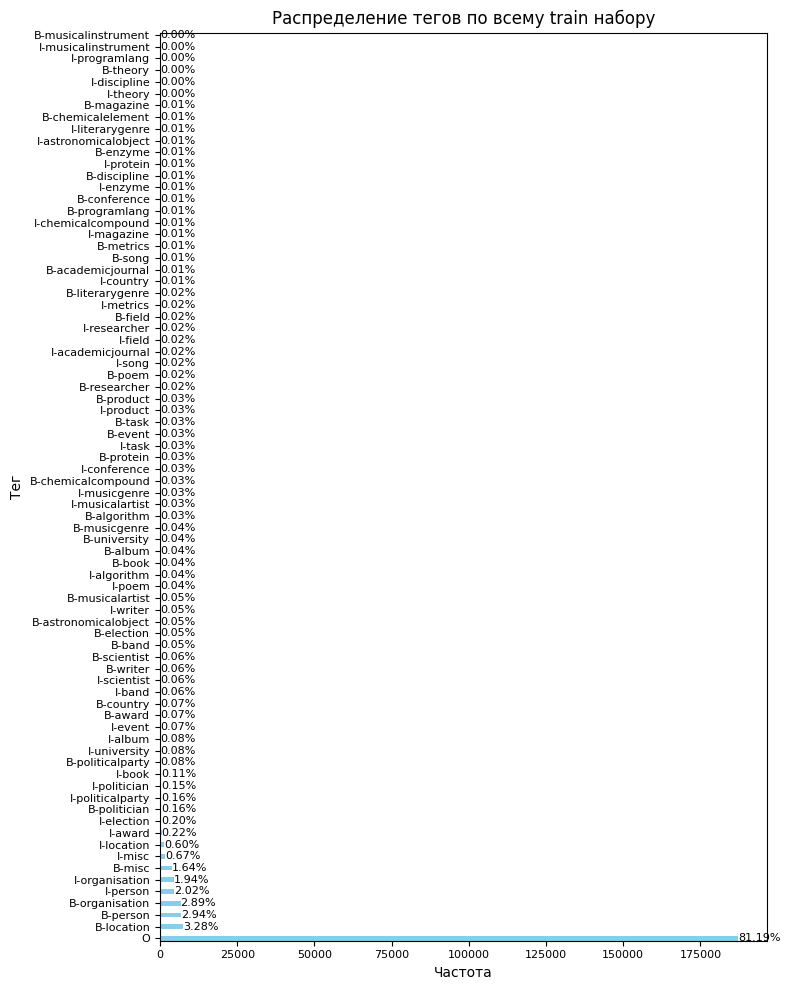

In [ ]:
def plot_tag_distribution(df, title):
    # Подсчёт процентов
    total_count = df["count"].sum()
    df["percentage"] = df["count"] / total_count * 100

    # Сортируем
    df = df.sort_values(by="count", ascending=False).reset_index(drop=True)
    
    # Установка фиксированной высоты графика
    fig_height = 10  # Задаём фиксированную высоту
    fig_width = 8    # Ширина графика
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    # Уменьшаем высоту баров
    ax.barh(df["tag_id"], df["count"], color="skyblue", height=0.4)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Частота", fontsize=10)
    ax.set_ylabel("Тег", fontsize=10)

    # Добавляем проценты
    for i, row in df.iterrows():
        ax.text(row["count"] + 0.5, i, f"{row['percentage']:.2f}%", va='center', fontsize=8)
    
    # Уменьшаем шрифт подписей осей
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)

    # Уменьшаем отступы сверху и снизу
    plt.margins(y=0)  # Убираем лишние внутренние отступы
    plt.subplots_adjust(top=0.9, bottom=0.1)  # Настраиваем отступы графика
    plt.tight_layout()  # Автоматическая настройка для компактности
    plt.show()


# Пример для всего train набора
all_tags = []
for ex in dataset["train"]:
    all_tags.extend(ex["ner_tags"])

tag_counts = Counter(all_tags)
tag_counts_named = {id2tag[tag_id]: count for tag_id, count in tag_counts.items()}
df_tags = pd.DataFrame(list(tag_counts_named.items()), columns=["tag_id", "count"])

plot_tag_distribution(df_tags, "Распределение тегов по всему train набору")

Здесь мы рассматриваем сейчас только трейн набор, потому что распределение других сплитов не должно сильно отличаться в виду предыдущей картинкы пересечения классов (она одинаковая в каждом сплите). Единственное, что мы можем сразу сказать, так это то, что большинство токенов в обьединенном датасете, а именно 81% - имеют тег 'O', что для нас крайне много. Лишь 20% токенов - наиболее содержательны для нас.

Мы видим, что у нас есть больше половины тегов, который встречаются меньше чем 0.2% от общего числа данных - это очень плохо. Из-за этого сильно повышается вероятность не быть способными распознавать эти теги. Возможно в конечном итоге лучше обучать отдельные модели под каждый класс.

### Распределение тегов по каждому домену

Давайте посмотрим распределение тегов по каждому домену

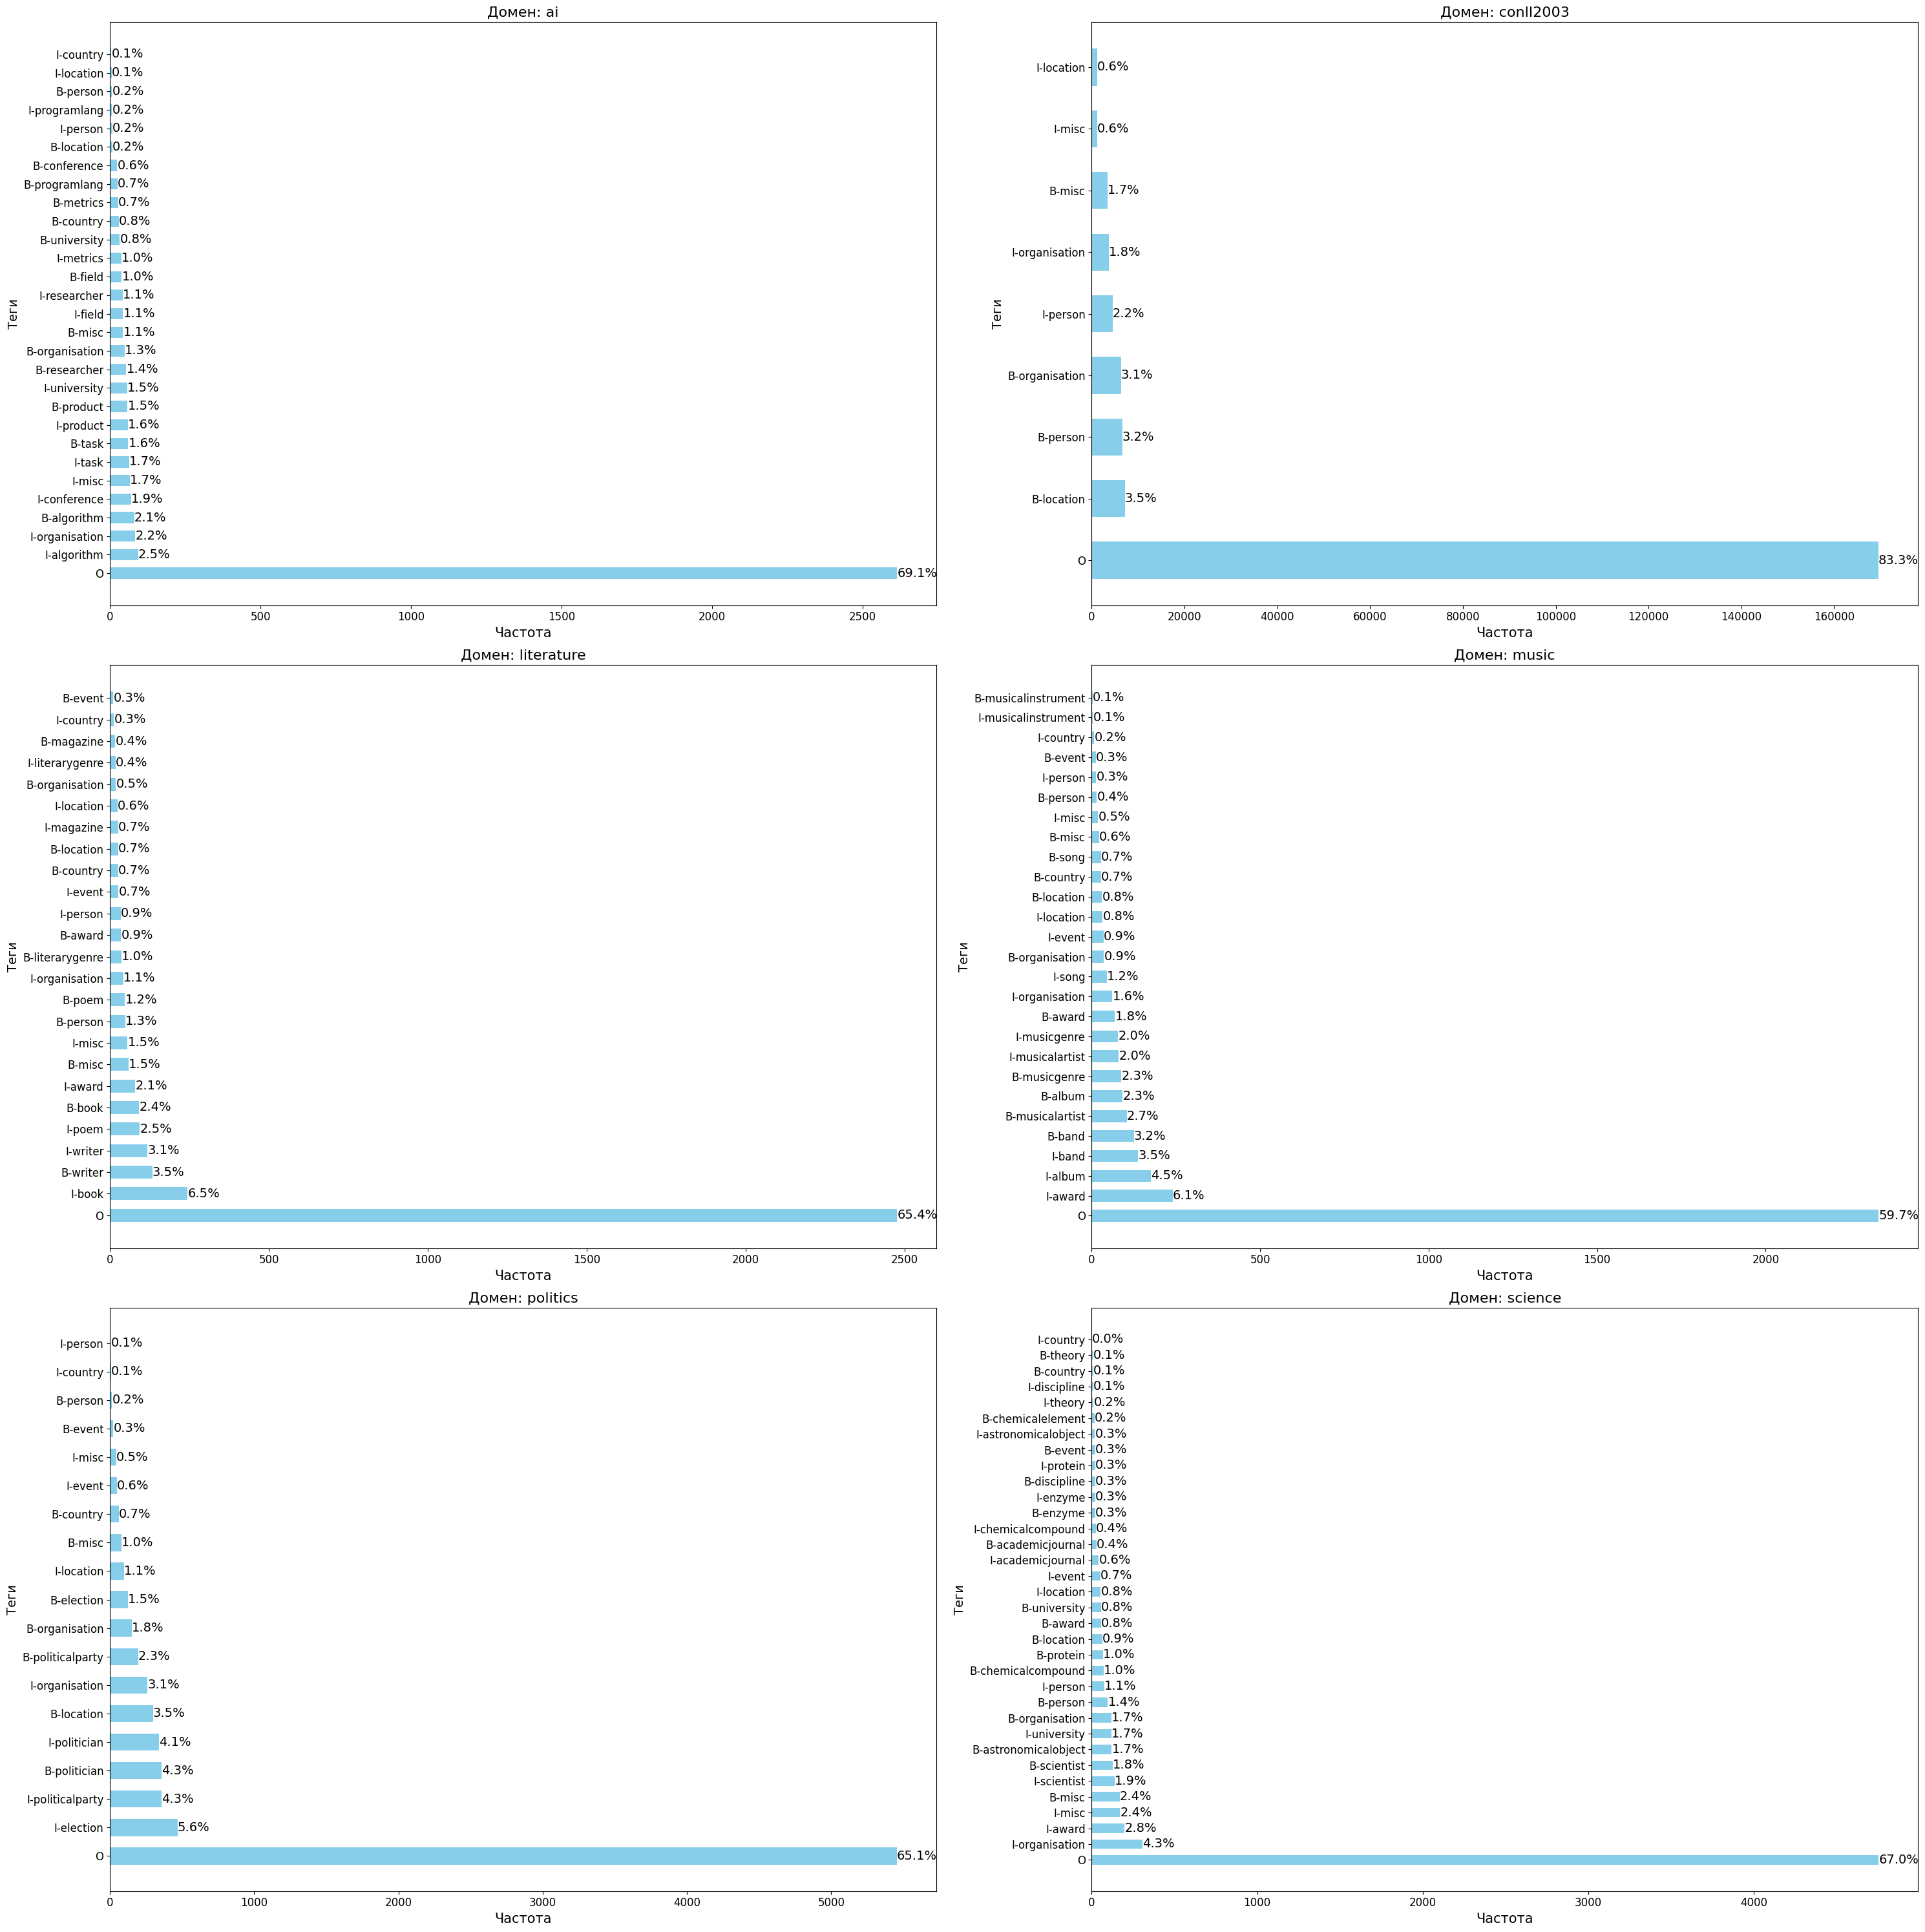

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

def get_domain_tag_counts(dataset, domain_name, id2tag):
    """
    Извлекает распределение тегов для заданного домена.
    """
    domain_examples = dataset.filter(lambda x: x["source"] == domain_name)
    all_tags = []
    for ex in domain_examples:
        all_tags.extend(ex["ner_tags"])
    counts = Counter(all_tags)
    named_counts = {id2tag[tag_id]: count for tag_id, count in counts.items()}
    return pd.DataFrame(list(named_counts.items()), columns=["tag_id", "count"])

def plot_tag_distribution_grid(dataset, id2tag, domains, cols=2):
    """
    Строит распределение тегов для каждого домена в виде сетки (решётки).
    """

    fig, axes = plt.subplots(3, 2, figsize=(cols * 10, 3 * 10))  # Увеличиваем общий размер графиков
    axes = axes.flatten()  # Преобразуем в одномерный массив для удобства

    for i, domain in enumerate(domains):
        # Получаем распределение тегов для домена
        df_domain = get_domain_tag_counts(dataset["train"], domain, id2tag)

        # Подсчёт процентов
        total_count = df_domain["count"].sum()
        df_domain["percentage"] = df_domain["count"] / total_count * 100

        # Сортировка и настройка высоты
        df_domain = df_domain.sort_values(by="count", ascending=False).reset_index(drop=True)
        height = 0.6  # Увеличиваем высоту баров для улучшения видимости

        # Рисуем график на текущей оси
        ax = axes[i]
        ax.barh(df_domain["tag_id"], df_domain["count"], color="skyblue", height=height)
        ax.set_title(f"Домен: {domain}", fontsize=16)
        ax.set_xlabel("Частота", fontsize=15)
        ax.set_ylabel("Теги", fontsize=14)

        # Добавляем проценты на график
        for j, row in df_domain.iterrows():
            ax.text(row["count"] + 0.5, j, f"{row['percentage']:.1f}%", va='center', fontsize=14)

        # Уменьшаем шрифт осей
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=12)
    
    # Удаляем пустые оси, если доменов меньше, чем ячеек
    for j in range(len(domains), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Запуск функции для построения сетки
plot_tag_distribution_grid(dataset, id2tag, domains, cols=3)


Действительно, в рамках каждого отдельного домена распределение тегов не выглядит таким катастрофическим. Большая часть тегов рамках каждого домена представлена в большем количестве, чем 1%. Скорее всего в рамках обучения, датасет с самым низким качеством будет science, поскольку там наибольшее число тегов с частотой встречаемости меньше 1%, почти половина токенов - сильно малочисленны.

Поэтому наша гипотеза о том, что стоит учить каждую отдельную модель на каждый из доменов - обретает все больший смысл. Узнаем это на этапе тестирования)

### Распределение B vs I

Теперь посмотрим, как выглядят наши теги в зависимости от домена по длине.

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np

def get_entity_distribution_by_domain(dataset, domain_name, id2tag):
    domain_examples = dataset.filter(lambda x: x["source"] == domain_name)
    all_tags = []
    for ex in domain_examples:
        all_tags.extend(ex["ner_tags"])
    
    tag_counts = Counter(all_tags)
    tag_counts_named = {id2tag[tag_id]: count for tag_id, count in tag_counts.items()}

    entity_data = {}
    for tag_name, count in tag_counts_named.items():
        if tag_name == 'O':
            continue
        parts = tag_name.split('-', 1)
        if len(parts) < 2:
            continue
        prefix, entity_type = parts[0], parts[1]

        if entity_type not in entity_data:
            entity_data[entity_type] = {"B_count": 0, "I_count": 0}

        if prefix == 'B':
            entity_data[entity_type]["B_count"] += count
        elif prefix == 'I':
            entity_data[entity_type]["I_count"] += count

    df_entity = pd.DataFrame.from_dict(entity_data, orient='index').fillna(0)
    # Сортируем по сумме чтобы более популярные сущности шли первыми
    df_entity["total"] = df_entity["B_count"] + df_entity["I_count"]
    df_entity = df_entity.sort_values(by="total", ascending=False).drop(columns=["total"], errors="ignore")
    return df_entity

def plot_entity_distribution_side_by_side(df_entity, domain_name):
    # Преобразуем DataFrame так, чтобы удобно строить две колонки
    entity_types = df_entity.index.tolist()
    B_values = df_entity["B_count"].values
    I_values = df_entity["I_count"].values

    x = np.arange(len(entity_types))  # позиции по оси X
    width = 0.35  # ширина столбика

    fig, ax = plt.subplots(figsize=(10, max(3, len(entity_types)*0.3)))
    # Рисуем столбцы для B и I рядом друг с другом
    ax.bar(x - width/2, B_values, width, label='B-теги', color='skyblue')
    ax.bar(x + width/2, I_values, width, label='I-теги', color='lightgreen')

    ax.set_title(f"Распределение B- и I-тегов по типам сущностей для домена {domain_name} (train)")
    ax.set_xlabel("Тип сущности")
    ax.set_ylabel("Частота")
    ax.set_xticks(x)
    ax.set_xticklabels(entity_types, rotation=45, ha='right')  # Повернём надписи сущностей для компактности
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_entity_distribution_domain(train_dataset, domain):
    df_entity = get_entity_distribution_by_domain(train_dataset, domain, id2tag)
    if not df_entity.empty:
        plot_entity_distribution_side_by_side(df_entity, domain)
    else:
        print(f"Для домена {domain} нет сущностей или данных.")


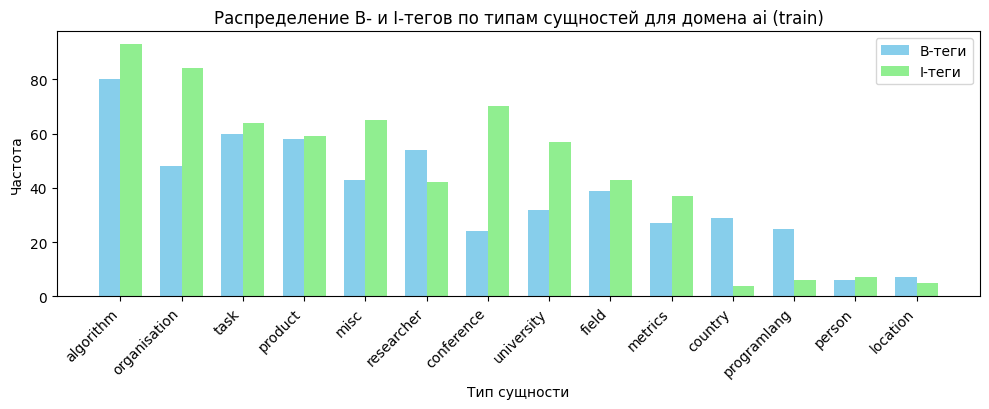

In [15]:
plot_entity_distribution_domain(dataset["train"], "ai")

Для ai домена мы видим, что такие теги как организация, конференция и университет, чаще имеют длину больше чем 1-2 слова. Оно и логично, потому что та же Высшая школа экономики состоит из 3 слов. Причем для этих слов разница почти в 1,5-2,5 раза, это значит, тег чаще всего состоит из 3-4 слов. Однако страна, как и язык программирования, чаще всего состоит именно из одного слова, потому что I-теги встречаются гораздо реже

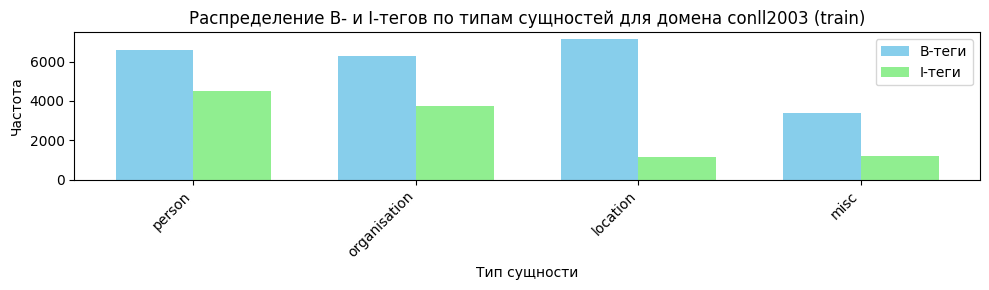

In [16]:
plot_entity_distribution_domain(dataset["train"], "conll2003")

Для домена conll2003 мы видим малую численность разных тегов и почти все они состоят из одного слова, встречаются теги, обозначающие человека (person), состоящие из двух, возможно 3ех слов.

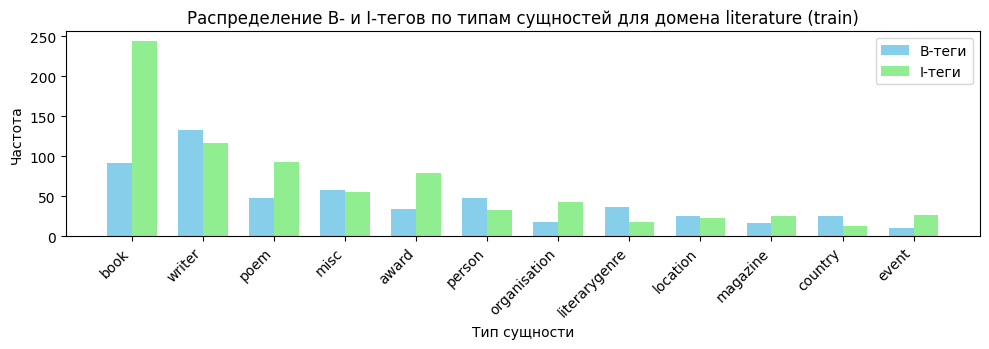

In [17]:
plot_entity_distribution_domain(dataset["train"], "literature")

В литературе мы видим большое количество слов именно в сущности обозначения книг. Вряд ли названия книг состоят из одного слова, обычно минимум два. Поэма, награда и организация тоже имеют больше 2-3 слов, обозначающих тег. Остальное придерживается 1-2 слов.

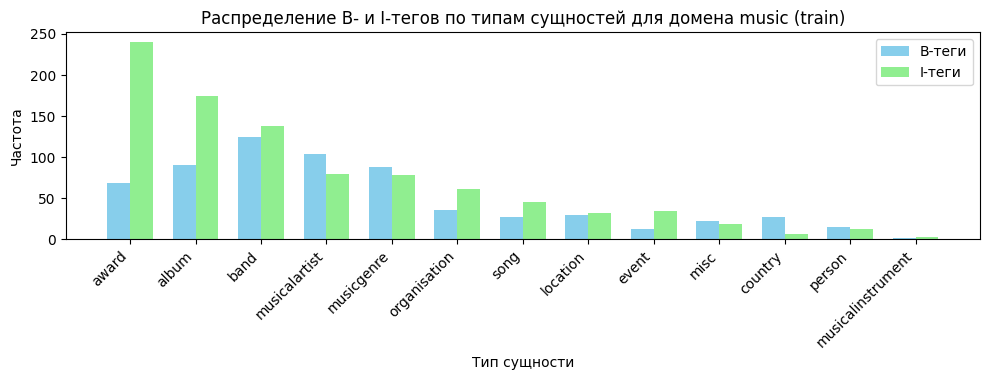

In [18]:
plot_entity_distribution_domain(dataset["train"], "music")

Описание сущностей музыки тоже имеет более длинные сущности, например, награда, альбом, организация содержат в себе скорее всего слова длины 3-4.

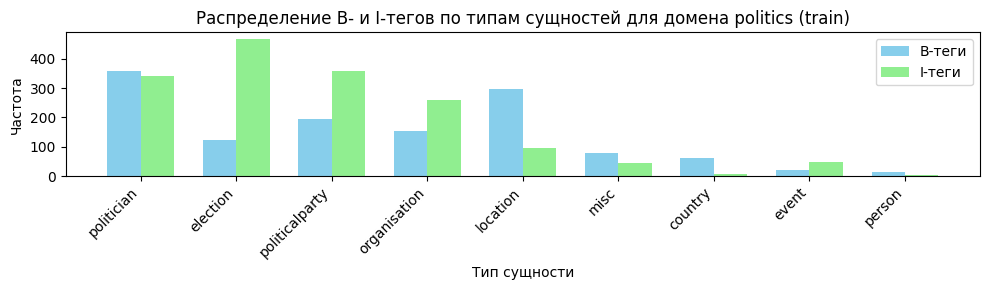

In [19]:
plot_entity_distribution_domain(dataset["train"], "politics")

В политике тег локация состоит из одного слова, в то время как сущность "выборы" состоит чаще из 3-4 слов.

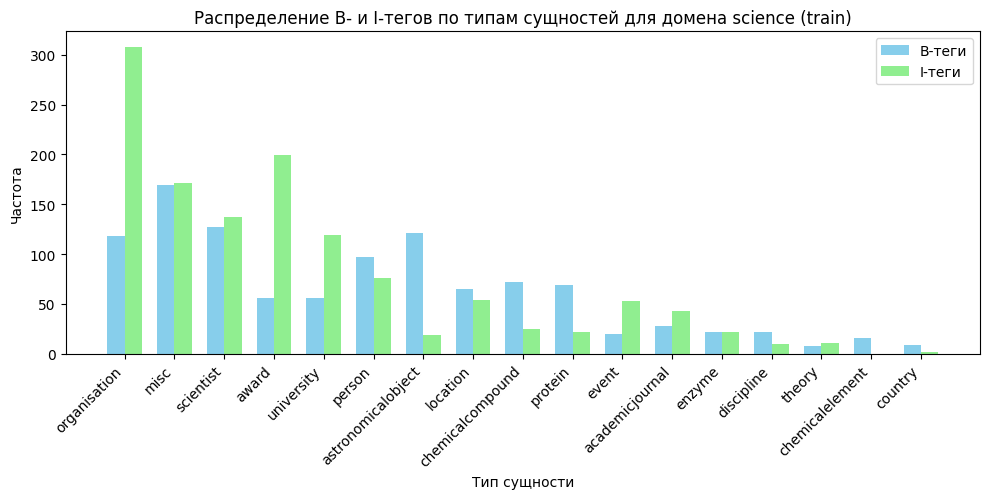

In [20]:
plot_entity_distribution_domain(dataset["train"], "science")

И наконец, наука, наименование организации, как и название университета или награды состоит больше чем из 2-3 слов, а вот астрономические обьекты и химическое соединение (chemicalcompound) состоят скорее всего из 1 слова.

## Анализ входных текстов

### Облака слов

Filter: 100%|██████████| 5959/5959 [00:00<00:00, 21617.82 examples/s]


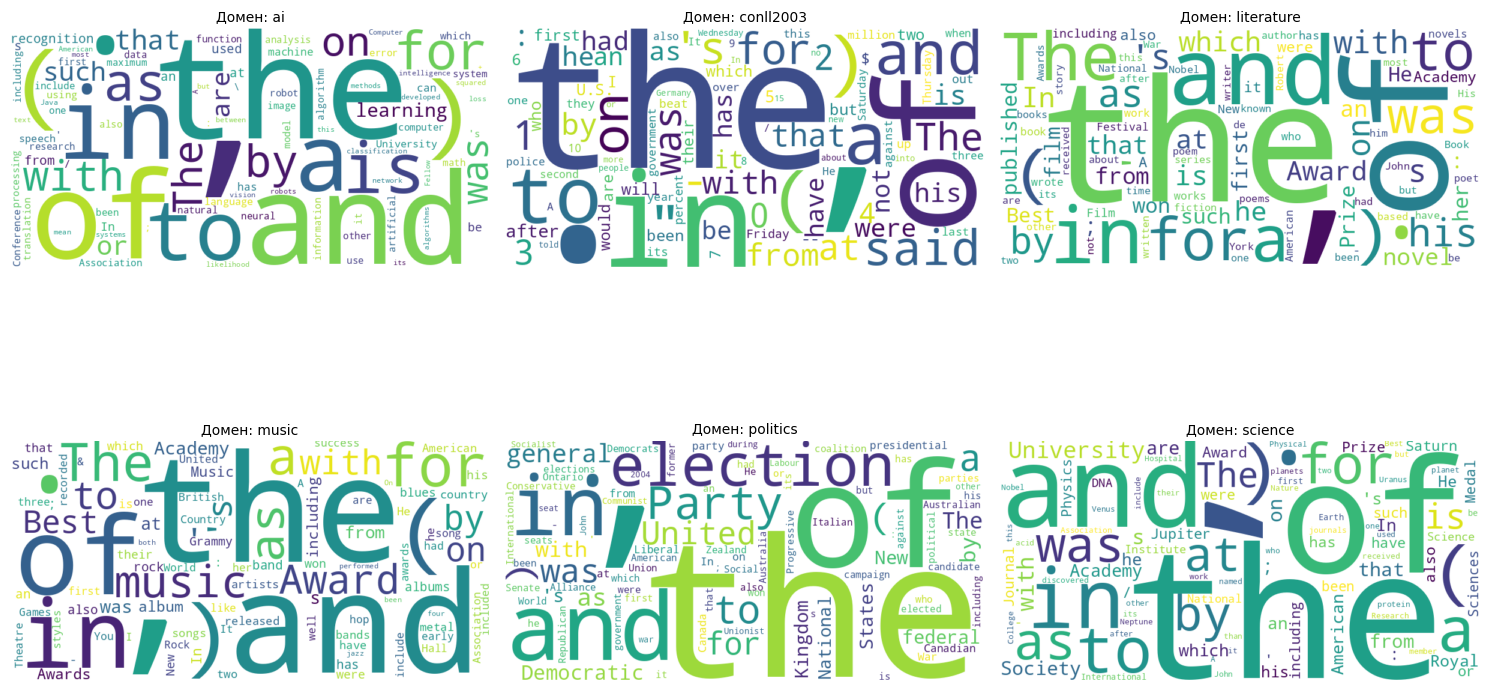

In [47]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import math

def get_domain_tokens(dataset, domain_name):
    """
    Извлекает все токены для заданного домена из датасета.
    """
    domain_examples = dataset.filter(lambda x: x["source"] == domain_name)
    all_tokens = []
    for ex in domain_examples:
        all_tokens.extend(ex["tokens"])
    return all_tokens

def plot_wordcloud_grid(dataset, max_words=100, cols=3):
    """
    Строит облака слов для каждого домена в виде сетки (решётки).
    """
    # Извлекаем уникальные домены
    domains = set()
    for split_name, split_dataset in dataset.items():
        domains.update(split_dataset["source"])
    domains = sorted(domains)  # Упорядочиваем домены

    # Определяем количество строк и столбцов для сетки
    rows = math.ceil(len(domains) / cols)

    # Создаём решётку
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()  # Преобразуем в одномерный массив для удобства

    for i, domain in enumerate(domains):
        # Собираем токены для домена из всех частей датасета
        tokens = []
        for split_name, split_dataset in dataset.items():
            tokens.extend(get_domain_tokens(split_dataset, domain))
        
        # Если токенов нет, пропускаем
        if not tokens:
            continue
        
        # Считаем частоты слов
        counter = Counter(tokens)
        # Генерируем облако слов
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              max_words=max_words, colormap='viridis').generate_from_frequencies(dict(counter))
        
        # Рисуем облако слов на текущей оси
        ax = axes[i]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Домен: {domain}", fontsize=10)
        ax.axis("off")

    # Удаляем лишние оси (если графиков меньше, чем ячеек)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Настраиваем отступы и отображаем график
    plt.tight_layout()
    plt.show()

# Вызываем функцию для построения решётки облаков слов
plot_wordcloud_grid(dataset, max_words=100, cols=3)

Мы видим еще один момент, который может навредить нашему обучению, а именно - общие слова: the, and, in, that, with

И только потом, более мелкими мы видим слова, содержащие смысловой окрас именно для каждого домена: например, для науки это: DNA, Academy, University, Association. Для музыки это стили: rock, metal.

### Очистка на стоп слова

In [92]:
def clean_tokens(example):
    original_tokens = example["tokens"]
    original_tags = example["ner_tags"]
    
    cleaned = []
    cleaned_tags = []
    removed_tokens = []  # Храним удаленные токены и их теги
    tag_names = []
    
    for token, tag_id in zip(original_tokens, original_tags):
        tag_name = id2tag[tag_id]
        tag_names.append(tag_name)
        # Проверяем стоп-слово
        if token.lower() in stop_words:
            # Стоп-слово: добавляем в список удаленных только если тег важный
            if tag_name != "O":
                removed_tokens.append({"token": token, "tag": tag_name})
            continue
        # Если не стоп-слово, оставляем
        cleaned.append(token)
        cleaned_tags.append(tag_id)
    
    # Возвращаем очищенные токены и удаленные важные токены
    return {
        "cleaned_tokens": cleaned,
        "removed_tokens": removed_tokens, 
        "cleaned_tags" : cleaned_tags,
        "tags_named" : tag_names  # Сохраняем удаленные
    }


# Подсчёт статистики: смотрим на все удаленные токены с важными тегами
def analyze_removed_tokens(dataset, dataset_name):
    all_removed = []
    for removed in dataset["removed_tokens"]:
        all_removed.extend(removed)
    
    # Подсчитываем наиболее часто удаляемые важные токены
    if all_removed:
        df_removed = pd.DataFrame(all_removed)
        removed_stats = df_removed.value_counts().reset_index(name="count")
        removed_stats.columns = ["token", "tag", "count"]
        print(f"\nТоп удаленных токенов с важными тегами ({dataset_name}):")
        print(removed_stats.head(10))
    else:
        print(f"\nВ {dataset_name} не было удалено токенов с важными тегами.")


for split in dataset.keys():
    dataset[split] = dataset[split].map(clean_tokens)
    analyze_removed_tokens(dataset[split], split)

Map: 100%|██████████| 14741/14741 [00:01<00:00, 10452.24 examples/s]



Топ удаленных токенов с важными тегами (train):
              token  tag  count
0    I-organisation   of    186
1    I-organisation  and     72
2           I-award  for     45
3  I-politicalparty   of     45
4      I-university   of     40
5            I-misc   of     36
6    I-organisation  for     30
7            I-book   of     29
8           I-award   of     26
9            B-book  The     25


Map: 100%|██████████| 5371/5371 [00:00<00:00, 10242.07 examples/s]



Топ удаленных токенов с важными тегами (val):
              token  tag  count
0    I-organisation   of    257
1  I-politicalparty   of    225
2           I-award  for    142
3            B-book  The     97
4            I-book   of     79
5    I-organisation  for     79
6      I-university   of     74
7    I-organisation  and     62
8            I-misc   of     54
9            I-book  the     53


Map: 100%|██████████| 5959/5959 [00:00<00:00, 8552.84 examples/s] 


Топ удаленных токенов с важными тегами (test):
              token  tag  count
0    I-organisation   of    268
1  I-politicalparty   of    188
2           I-award  for    148
3            B-book  The    137
4            I-book   of     90
5      I-university   of     80
6           I-award   of     73
7    I-organisation  for     72
8    I-organisation  and     70
9            B-band  The     59


In [81]:
dataset["train"]

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'source', 'cleaned_tokens', 'removed_tokens', 'cleaned_tags', 'tags_named'],
    num_rows: 14741
})

То есть если мы удаляем стоп слова есть вероятность зацепить внутренние связки между словами, которые определяются тегом I-<entry> и так же удаляются предлоги, обозначающие начало связки, как например у B-band, скорее всего название начинается как-нибудь "The ....".

Мы можем продолжить работу с очищенным словарем, но тогда надо тогда понять, как заменять эти пробелы на этапе инференса на тесте, если мы их удаляем.

### Распредение длины предложений

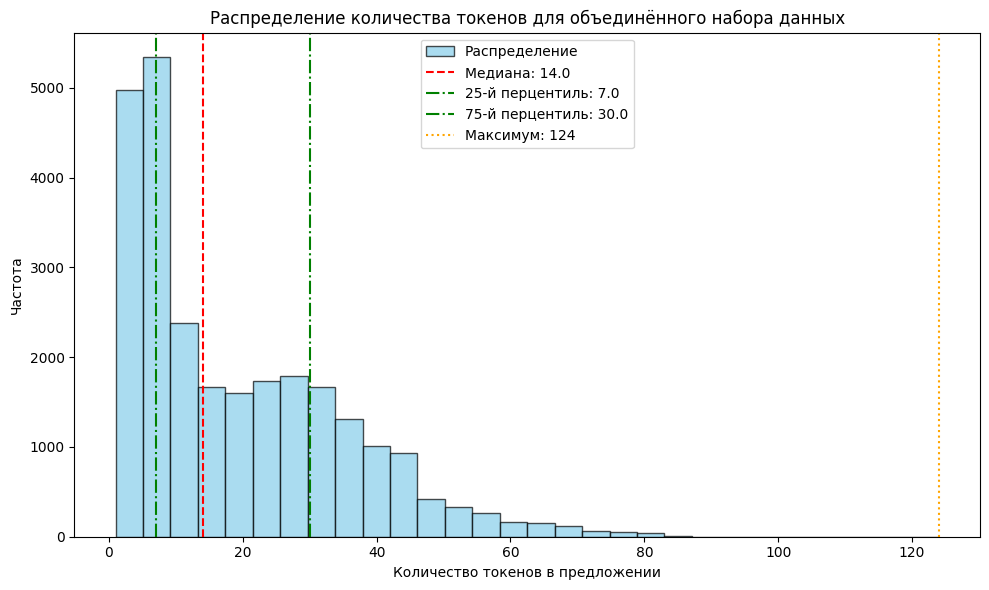

In [43]:
def plot_combined_token_distribution(dataset, percentiles=[25, 75]):
    """
    Рассчитывает распределение количества токенов в предложениях
    для объединённого набора данных и строит гистограмму с медианой,
    перцентилями и максимальным значением.
    """
    # Объединяем все токены из train, val, test в один список
    lengths = []
    for split_name, split_dataset in dataset.items():
        lengths.extend([len(tokens) for tokens in split_dataset["tokens"]])
    
    # Рассчитываем медиану, перцентили и максимальное значение
    median = np.median(lengths)
    perc_values = np.percentile(lengths, percentiles)
    max_value = np.max(lengths)

    # Построим гистограмму
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=30, color="skyblue", edgecolor="black", alpha=0.7, label="Распределение")
    
    # Добавляем медиану
    plt.axvline(median, color="red", linestyle="--", label=f"Медиана: {median}")
    
    # Добавляем перцентили
    for p, val in zip(percentiles, perc_values):
        plt.axvline(val, color="green", linestyle="-.", label=f"{p}-й перцентиль: {val}")
    
    # Добавляем максимальное значение
    plt.axvline(max_value, color="orange", linestyle=":", label=f"Максимум: {max_value}")
    
    # Настраиваем график
    plt.title("Распределение количества токенов для объединённого набора данных")
    plt.xlabel("Количество токенов в предложении")
    plt.ylabel("Частота")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Вызываем функцию для объединённого набора данных
plot_combined_token_distribution(dataset, percentiles=[25, 75])

Таким образом, мы видим, что у нас есть совсем мало, но предложений большой длины. Давайте посмотрим в разрезе доменов:

Filter: 100%|██████████| 5959/5959 [00:00<00:00, 20983.21 examples/s]


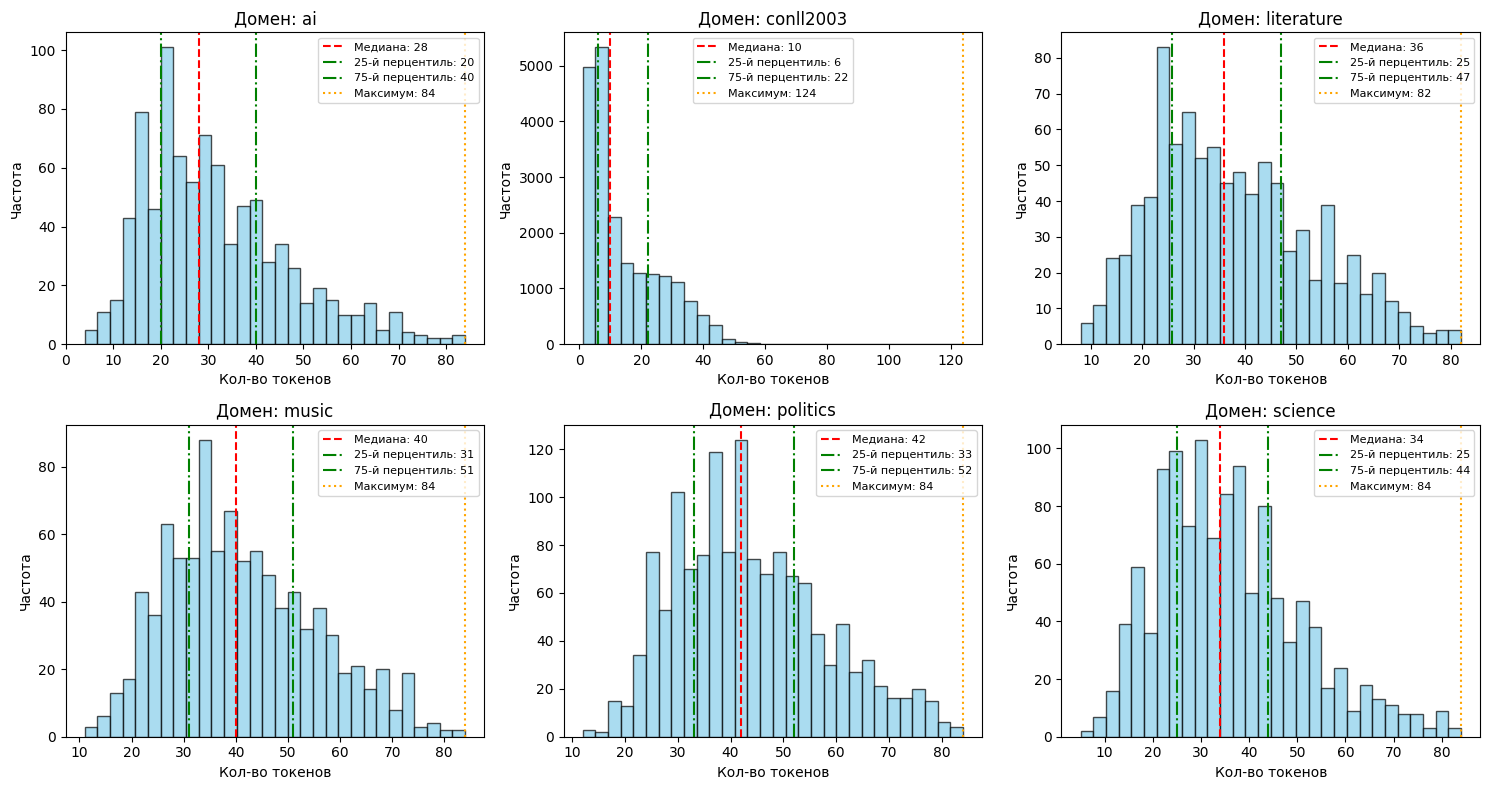

In [46]:


def plot_token_distribution_grid(dataset, percentiles=[25, 75], cols=3):
    """
    Строит гистограммы распределения количества токенов для каждого домена
    в виде сетки (решётки).
    """
    # Извлекаем уникальные домены
    domains = set()
    for split_name, split_dataset in dataset.items():
        domains.update(split_dataset["source"])
    domains = sorted(domains)  # Упорядочиваем домены

    # Определяем количество строк и столбцов для графиков
    rows = math.ceil(len(domains) / cols)
    
    # Создаём решётку
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Преобразуем в одномерный массив для удобства

    for i, domain in enumerate(domains):
        # Объединяем длины предложений для текущего домена из всех частей (train, val, test)
        lengths = []
        for split_name, split_dataset in dataset.items():
            domain_examples = split_dataset.filter(lambda x: x["source"] == domain)
            lengths.extend([len(tokens) for tokens in domain_examples["tokens"]])
        
        # Рассчитываем статистики
        median = np.median(lengths)
        perc_values = np.percentile(lengths, percentiles)
        max_value = np.max(lengths)
        
        # Строим гистограмму на текущей оси
        ax = axes[i]
        ax.hist(lengths, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
        ax.axvline(median, color="red", linestyle="--", label=f"Медиана: {int(median)}")
        for p, val in zip(percentiles, perc_values):
            ax.axvline(val, color="green", linestyle="-.", label=f"{p}-й перцентиль: {int(val)}")
        ax.axvline(max_value, color="orange", linestyle=":", label=f"Максимум: {int(max_value)}")
        
        # Подписываем график
        ax.set_title(f"Домен: {domain}")
        ax.set_xlabel("Кол-во токенов")
        ax.set_ylabel("Частота")
        ax.legend(fontsize=8)
    
    # Удаляем пустые оси (если графиков меньше, чем ячеек)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Настраиваем отступы и выводим график
    plt.tight_layout()
    plt.show()

# Вызываем функцию для построения решётки
plot_token_distribution_grid(dataset, percentiles=[25, 75], cols=3)


Интересный момент, что для всех доменов, кроме сonll2003, мы видим чуть близкое к нормальному распределению и длина предложений у нас лежит в от 10 до 85 слов (токенов). А сonll2003 вообще не распределен нормально и половина (по медиане) текстов содержат меньше 10 слов в предложении. Однако другая половина сильно растянулась, 25% текстов имеют длину от 22 слов до 124.

Вероятнее всего, при таком раскладе действительно стоит отдельную модель под каждый домен, нежели чем одну общую. Или попытаться например, обучить на 5 доменах одну и на 1 домене (сonll2003) другую. Эти соображения аргументированы тем, что модель на домене сonll2003 скорее всего будет больше смотреть и лучше выявлять сущности вначале, а на более длинных текстах будет больший процент ошибки - их просто мало. В то время как на других доменах модель будет акцентироваться на текстах до 80 токенов и при большем количестве - вероятнее всего будет ошибаться.

### Пересечение вокабуляра

Filter: 100%|██████████| 5959/5959 [00:00<00:00, 21262.27 examples/s]


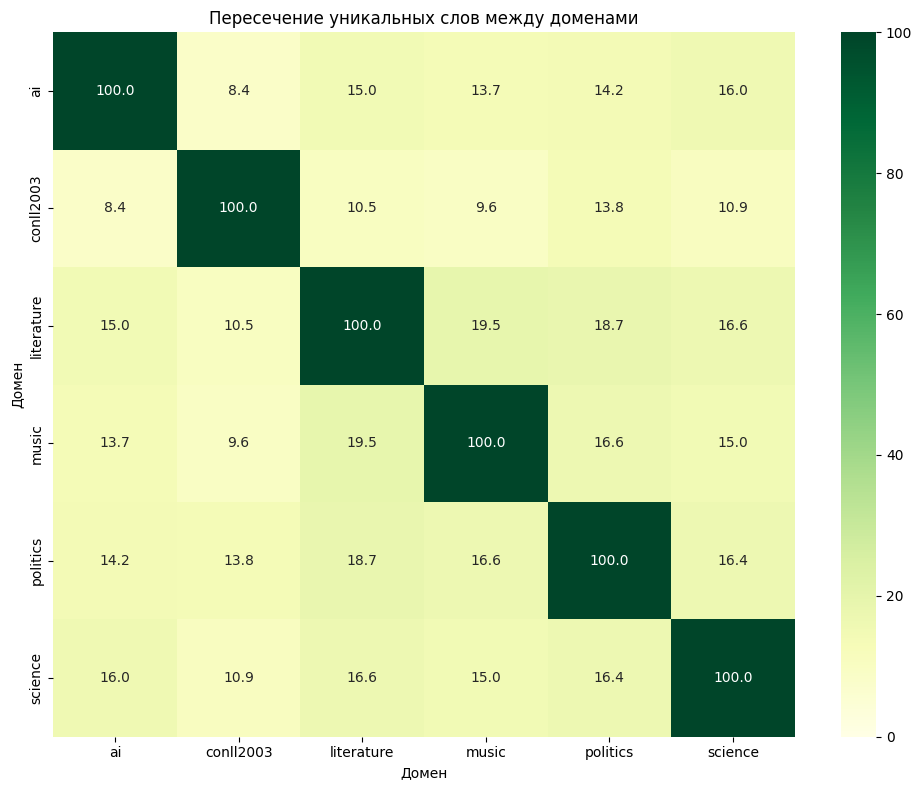

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_unique_tokens_by_domain(dataset, domains):
    """
    Собирает уникальные слова для каждого домена.
    """
    domain_tokens = {}
    for domain in domains:
        all_tokens = []
        for split_name, split_dataset in dataset.items():
            domain_examples = split_dataset.filter(lambda x: x["source"] == domain)
            for ex in domain_examples:
                all_tokens.extend(ex["tokens"])
        domain_tokens[domain] = set(all_tokens)
    return domain_tokens

def compute_token_overlap_matrix(domain_tokens):
    """
    Рассчитывает матрицу пересечения уникальных слов между доменами.
    """
    domains = list(domain_tokens.keys())
    matrix = pd.DataFrame(index=domains, columns=domains, data=0.0)
    
    for d1 in domains:
        for d2 in domains:
            set1 = domain_tokens[d1]
            set2 = domain_tokens[d2]
            intersection = set1.intersection(set2)
            union = set1.union(set2)
            overlap = (len(intersection) / len(union)) * 100 if len(union) > 0 else 0.0
            matrix.loc[d1, d2] = overlap
    
    return matrix

def plot_overlap_heatmap(matrix, title):
    """
    Визуализирует матрицу пересечений в виде тепловой карты.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=".1f", cmap="YlGn", vmin=0, vmax=100)
    plt.title(title)
    plt.xlabel("Домен")
    plt.ylabel("Домен")
    plt.tight_layout()
    plt.show()

# Получаем уникальные слова для каждого домена
domain_tokens = get_unique_tokens_by_domain(dataset, domains)

# Рассчитываем матрицу пересечения уникальных слов
token_overlap_matrix = compute_token_overlap_matrix(domain_tokens)

# Визуализируем пересечение
plot_overlap_heatmap(token_overlap_matrix, "Пересечение уникальных слов между доменами")


Интересно, что в контексте пересечения вокабуляра - пересечение текстов больше между квадратом -литература, музыка, политика и наука, а меньше всего пересечения именно у conll2003 домена.

## Токенизация

### Обучение токенайзера на train и val

In [24]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from collections import Counter
import itertools

# Соберем все токены из train и val
def collect_all_tokens(datasets):
    all_tokens = []
    for dataset in datasets:
        for tokens in dataset["tokens"]:
            all_tokens.extend(tokens)
    return all_tokens

# Объединяем train и val
all_tokens = collect_all_tokens([dataset["train"], dataset["val"]])

# Подсчитываем частоты
word_counts = Counter(all_tokens)
word_counts

# Создаём словарь: добавляем токен `<OOV>` для неизвестных слов
MAX_WORDS_TOKENIZER = 35000
vocab = {"<PAD>": 0, "<OOV>": 1}  # Резервируем индексы 0 и 1 для PAD и OOV
most_common = word_counts.most_common(MAX_WORDS_TOKENIZER - len(vocab))

# Добавляем слова в словарь
for i, (word, _) in enumerate(most_common, start=len(vocab)):
    vocab[word] = i

# Создаем токенайзер WordLevel
tokenizer = Tokenizer(WordLevel(vocab, unk_token="<OOV>"))
tokenizer.pre_tokenizer = Whitespace()  # Токенизация по пробелам

# Проверим токенизацию
print(tokenizer.encode("This is an example sentence.").tokens)
print(tokenizer.encode("This is an unknownword!").ids)

# Сохранение токенайзера
tokenizer.save("word_level_tokenizer.json")

['This', 'is', 'an', 'example', 'sentence', '.']
[265, 27, 34, 1, 2321]


In [25]:
# Функция для кодирования токенов с использованием токенайзера
def encode_dataset(dataset, tokenizer, max_len):
    encoded_sequences = []
    for tokens in dataset["tokens"]:
        # Кодируем последовательность
        encoded = tokenizer.encode(" ".join(tokens)).ids
        # Применяем паддинг или обрезку
        if len(encoded) > max_len:
            encoded = encoded[:max_len]  # Обрезаем до max_len
        else:
            encoded += [0] * (max_len - len(encoded))  # Паддинг токеном <PAD> (0)
        encoded_sequences.append(encoded)
    return np.array(encoded_sequences)

In [ ]:
# Функция для кодирования тегов с паддингом
def encode_tags(dataset, max_len, pad_tag_id=0):
    encoded_tags = []
    for tags in dataset["ner_tags"]:
        # Если длина больше max_len, обрезаем
        if len(tags) > max_len:
            encoded = tags[:max_len]
        else:
            # Если длина меньше max_len, добавляем паддинг с использованием pad_tag_id
            encoded = tags + [pad_tag_id] * (max_len - len(tags))
        encoded_tags.append(encoded)
    return np.array(encoded_tags)


### Кодирование токенайзера

In [65]:
MAX_SEQUENCE_LENGTH = 128  # Максимальная длина последовательности
PAD_TAG_ID = 79  # Индекс для паддинга тегов

# Словарь для хранения закодированных данных по разбиениям и поддоменам
encoded_datasets = defaultdict(lambda: defaultdict(dict))

def filter_by_domain(dataset, domain):
    """
    Фильтрует датасет по поддомену.
    """
    return dataset.filter(lambda x: x["source"] == domain)

# Кодируем данные для каждого разбиения и поддомена
for split_name, dataset_el in tqdm(dataset.items(), desc="Обработка по сплиту"):

    for domain in tqdm(domains, "Обработанные домены"):

        # Фильтруем датасет для текущего поддомена
        domain_dataset = filter_by_domain(dataset_el, domain)

        # Кодируем токены и теги
        tokens_matrix = encode_dataset(domain_dataset, tokenizer, MAX_SEQUENCE_LENGTH)
        tags_matrix = encode_tags(domain_dataset, MAX_SEQUENCE_LENGTH, PAD_TAG_ID)

        # Сохраняем кодированные данные
        encoded_datasets[split_name][domain] = {
            "inputs": tokens_matrix,
            "labels": tags_matrix
        }

# Проверка результата
split_name = "train"
domain = "ai"
print(f"{split_name} -> {domain} example inputs:", encoded_datasets[split_name][domain]["inputs"][0])
print(f"{split_name} -> {domain} example labels:", encoded_datasets[split_name][domain]["labels"][0])

Обработка по сплиту: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

train -> ai example inputs: [ 1684  9534     5  3058    19   441  7741   416 18356   973  2472   103
  1932  1761     2   879  5018     2  3734  1130    11   656    63 18357
  3734  1130    10     6  2634   597  3638     4  8850     4 12320     2
     1     4  9535     2  8850     4  8055     4  9536     2  5873     4
     1     4 18361     2  8850     4 12322     2  8850     4  1850     4
 18363     2  1938     4  1850     4 18365     2  1805     4  9537     2
    11  1326    10     2     2   262    11    57    10    31 18366     4
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
train -> ai example labels: [ 0  0  0 59 60 60  0  0  0  0 31 32  0 71 72  0 71 72  0  0  0 71 72 72
  0  0 31 32 65 66  0 65 66  0 65 66  0 65 66  0 65 66  0 65 66  0 65 66
  0 65 66  0  0  0

Так мы закодировали численно наши датасеты с входными токенами и выходные теги, чтобы размерность была одинаковая. При этом, оставили домены отделенными, чтобы была возможность если что обучить отдельные модели.

## Получение эмбеддингов

# Rule-based method

## Выбор фреймворка для задачи NER

Для решения задачи распознавания именованных сущностей (NER) на английсклом языке мы выбрали **SpaCy**. 

SpaCy имеет мощную поддержку английского языка и предоставляет готовые модели для NER, обученные на больших наборах данных.

## Первое решение

In [78]:
rb_model = spacy.load('en_core_web_md')

ner = rb_model.get_pipe("ner") # NER компонент из nlp pipeline

print("Доступные сущности (теги):")
for label in ner.labels:
    print(f"* {label} — {spacy.explain(label)}")

Доступные сущности (теги):
* CARDINAL — Numerals that do not fall under another type
* DATE — Absolute or relative dates or periods
* EVENT — Named hurricanes, battles, wars, sports events, etc.
* FAC — Buildings, airports, highways, bridges, etc.
* GPE — Countries, cities, states
* LANGUAGE — Any named language
* LAW — Named documents made into laws.
* LOC — Non-GPE locations, mountain ranges, bodies of water
* MONEY — Monetary values, including unit
* NORP — Nationalities or religious or political groups
* ORDINAL — "first", "second", etc.
* ORG — Companies, agencies, institutions, etc.
* PERCENT — Percentage, including "%"
* PERSON — People, including fictional
* PRODUCT — Objects, vehicles, foods, etc. (not services)
* QUANTITY — Measurements, as of weight or distance
* TIME — Times smaller than a day
* WORK_OF_ART — Titles of books, songs, etc.


Ключевая проблема сразу: у нас сильно больше сущностей, прямо очень, мы можем попытаться уйти от такого количества класса, что конечно решение, но немного такое себе. Но давайте на текущем этапе попробуем так.

In [84]:
custom_to_spacy = {
    # PERSON-related entities
    "B-person": "PERSON",
    "I-person": "PERSON",
    "B-writer": "PERSON",
    "I-writer": "PERSON",
    "B-researcher": "PERSON",
    "I-researcher": "PERSON",
    "B-politician": "PERSON",
    "I-politician": "PERSON",
    "B-scientist": "PERSON",
    "I-scientist": "PERSON",

    # ORG-related entities
    "B-organisation": "ORG",
    "I-organisation": "ORG",
    "B-university": "ORG",
    "I-university": "ORG",
    "B-band": "ORG",
    "I-band": "ORG",
    "B-politicalparty": "ORG",
    "I-politicalparty": "ORG",

    # GPE-related entities (countries)
    "B-country": "GPE",
    "I-country": "GPE",

    # LOC-related entities
    "B-location": "LOC",
    "I-location": "LOC",
    "B-astronomicalobject": "LOC",
    "I-astronomicalobject": "LOC",

    # WORK_OF_ART-related entities
    "B-book": "WORK_OF_ART",
    "I-book": "WORK_OF_ART",
    "B-poem": "WORK_OF_ART",
    "I-poem": "WORK_OF_ART",
    "B-song": "WORK_OF_ART",
    "I-song": "WORK_OF_ART",
    "B-album": "WORK_OF_ART",
    "I-album": "WORK_OF_ART",
    "B-literarygenre": "WORK_OF_ART",
    "I-literarygenre": "WORK_OF_ART",

    # PRODUCT-related entities
    "B-product": "PRODUCT",
    "I-product": "PRODUCT",
    "B-musicalinstrument": "PRODUCT",
    "I-musicalinstrument": "PRODUCT",
    "B-algorithm": "PRODUCT",
    "I-algorithm": "PRODUCT",
    "B-theory": "PRODUCT",
    "I-theory": "PRODUCT",

    # EVENT-related entities
    "B-event": "EVENT",
    "I-event": "EVENT",
    "B-conference": "EVENT",
    "I-conference": "EVENT",
    "B-election": "EVENT",
    "I-election": "EVENT",
    "B-award": "EVENT",
    "I-award": "EVENT",
    
    "B-discipline": "PRODUCT",
    "I-discipline": "PRODUCT",

    # LANGUAGE-related entities
    "B-programlang": "LANGUAGE",
    "I-programlang": "LANGUAGE",

    # LAW-related entities
    "B-misc": "LAW",
    "I-misc": "LAW",

    "B-metrics": "QUANTITY",
    "I-metrics": "QUANTITY",

    # ORDINAL-related entities
    "B-task": "PRODUCT",
    "I-task": "PRODUCT",

    # QUANTITY-related entities
    "B-field": "QUANTITY",
    "I-field": "QUANTITY",

    # CHEMICAL-related entities
    "B-chemicalcompound": "PRODUCT",
    "I-chemicalcompound": "PRODUCT",
    "B-chemicalelement": "PRODUCT",
    "I-chemicalelement": "PRODUCT",
    "B-enzyme": "PRODUCT",
    "I-enzyme": "PRODUCT",
    "B-protein": "PRODUCT",
    "I-protein": "PRODUCT",

    # Default
    "O": "O"
}

In [ ]:
def map_custom_to_spacy(custom_tag, custom_to_spacy):
    """
    Преобразует кастомный тег в соответствующий тег SpaCy.
    Если тег отсутствует в маппинге, возвращает "O".
    """
    return custom_to_spacy.get(custom_tag, "O")

In [130]:
def evaluate_ner_per_domain(dataset, nlp, custom_to_spacy, domains):
    """
    Рассчитывает метрики и возвращает разметку для каждого домена.
    """
    domain_results = {}
    all_annotations = []

    for domain in domains:
        print(f"Обрабатываем домен: {domain}")

        # Фильтруем примеры по домену
        domain_examples = dataset.filter(lambda x: x["source"] == domain)

        all_y_true = []
        all_y_pred = []
        annotations = []

        for example in domain_examples:
            tokens = example["tokens"]
            gold_tags = example["tags_named"]  # Золотые теги в кастомном формате

            # Преобразуем золотые теги в формат SpaCy
            transformed_gold_tags = [map_custom_to_spacy(tag, custom_to_spacy) for tag in gold_tags]

            # Преобразуем токены в текст
            text = " ".join(tokens)

            # Предсказания SpaCy
            doc = nlp(text)
            predicted_tags = ["O"] * len(tokens)  # Инициализация предсказанных тегов

            for ent in doc.ents:
                # Определяем начало и конец сущностей
                start_idx = len(" ".join(tokens[:ent.start]).split())
                end_idx = len(" ".join(tokens[:ent.end]).split())

                # Применяем тег, предсказанный SpaCy
                for i in range(start_idx, min(end_idx, len(tokens))):
                    predicted_tags[i] = ent.label_

            # Проверяем длины и сохраняем теги
            if len(transformed_gold_tags) != len(predicted_tags):
                print(f"Ошибка! Несоответствие длины для текста: {text}")
                print(f"gold_tags: {len(transformed_gold_tags)}, predicted_tags: {len(predicted_tags)}")
                continue

            # Сохраняем результаты
            all_y_true.extend(transformed_gold_tags)
            all_y_pred.extend(predicted_tags)

            annotations.append({
                "domain": domain,  # Добавляем информацию о домене
                "tokens": tokens,
                "gold_tags": transformed_gold_tags,
                "predicted_tags": predicted_tags
            })


        # Проверяем общую длину списков
        if len(all_y_true) != len(all_y_pred):
            raise ValueError(f"Несоответствие длины all_y_true ({len(all_y_true)}) и all_y_pred ({len(all_y_pred)}) для домена {domain}")

        # Рассчитываем метрики
        precision, recall, f1, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average="weighted")
        accuracy = accuracy_score(all_y_true, all_y_pred)

        # Сохраняем результаты метрик для домена
        domain_results[domain] = {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Accuracy": accuracy
        }

        # Добавляем аннотации для домена
        all_annotations.extend(annotations)

    # Преобразуем результаты метрик в DataFrame
    metrics_df = pd.DataFrame.from_dict(domain_results, orient="index").reset_index().rename(columns={"index": "Domain"})

    return metrics_df, all_annotations

# Пример применения к данным (val)
domains = ["ai", "conll2003", "literature", "music", "politics", "science"]
metrics_df, annotations = evaluate_ner_per_domain(dataset["val"], rb_model, custom_to_spacy, domains)

Обрабатываем домен: ai


/Users/ayuschenikova/Documents/master degree/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Обрабатываем домен: conll2003


/Users/ayuschenikova/Documents/master degree/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Обрабатываем домен: literature


/Users/ayuschenikova/Documents/master degree/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Обрабатываем домен: music


/Users/ayuschenikova/Documents/master degree/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Обрабатываем домен: politics


/Users/ayuschenikova/Documents/master degree/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Обрабатываем домен: science


/Users/ayuschenikova/Documents/master degree/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Метрики

### Общие

In [132]:
metrics_df

,Domain,Precision,Recall,F1-score,Accuracy
0,ai,0.647972,0.711787,0.645200,0.711787
1,conll2003,0.879024,0.747479,0.795827,0.747479
2,literature,0.759998,0.710129,0.713057,0.710129
3,music,0.685343,0.618690,0.623122,0.618690
4,politics,0.757929,0.698912,0.693512,0.698912
5,science,0.738216,0.708532,0.694461,0.708532


### Confusion matrics by domain and tag

Уникальные теги: ['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']


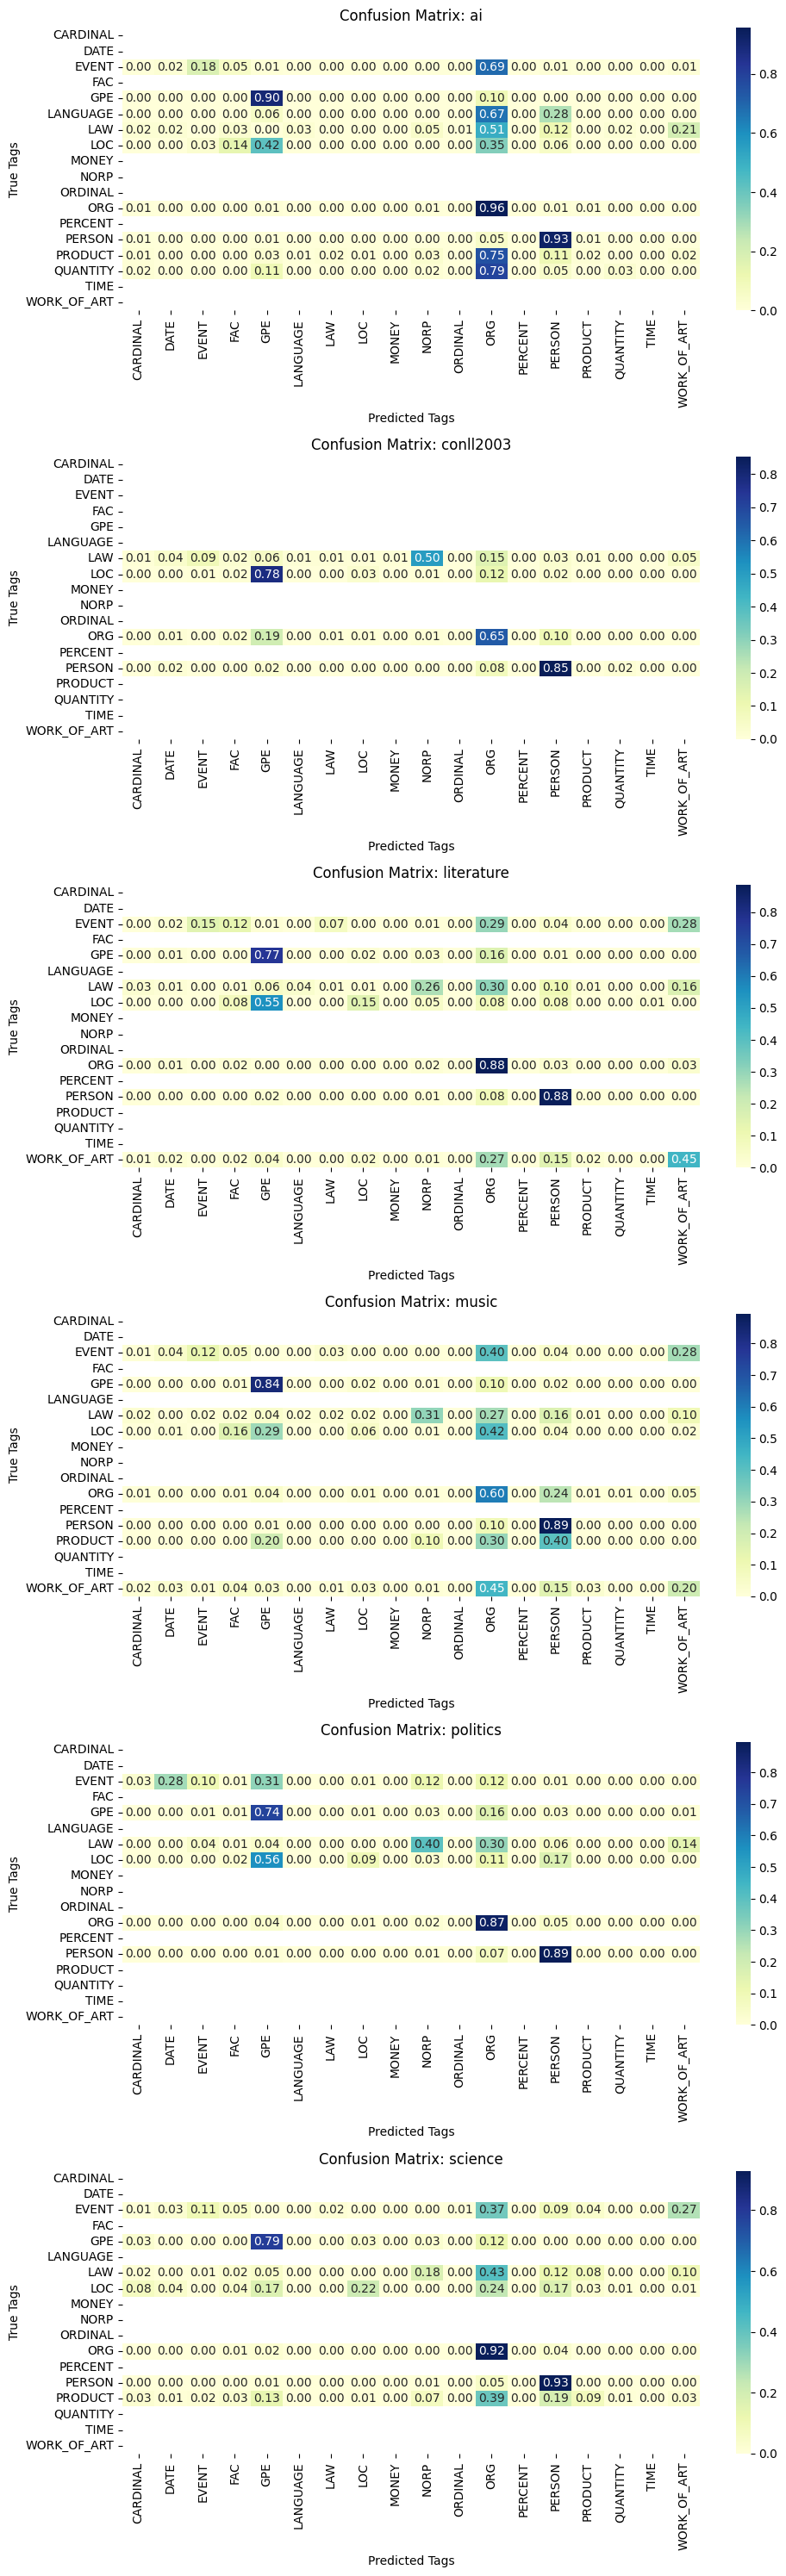

In [133]:
def plot_confusion_matrices_spacy_with_domains(annotations, domains):
    """
    Строит решетку матриц конфузий по каждому домену для тегов в формате SpaCy.
    """
    # Получаем уникальные теги из аннотаций (в формате SpaCy)
    unique_tags = sorted({tag for ann in annotations for tag in ann["gold_tags"] + ann["predicted_tags"] if tag != "O"})
    
    if not unique_tags:
        print("Ошибка: уникальные теги отсутствуют! Проверьте формат данных.")
        return

    print(f"Уникальные теги: {unique_tags}")

    # Определяем размеры решетки
    cols = 1  # Количество колонок
    rows = (len(domains) + cols - 1) // cols  # Количество строк
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 5))
    axes = axes.flatten()  # Преобразуем в 1D массив для удобства работы

    for idx, domain in enumerate(domains):
        # Отбираем аннотации для текущего домена
        domain_annotations = [ann for ann in annotations if ann["domain"] == domain]

        # Проверяем, есть ли аннотации для домена
        if not domain_annotations:
            print(f"Данные для домена '{domain}' отсутствуют.")
            axes[idx].axis('off')  # Отключаем пустую ось
            continue

        # Составляем списки золотых и предсказанных тегов
        y_true = []
        y_pred = []
        for ann in domain_annotations:
            y_true.extend(ann["gold_tags"])
            y_pred.extend(ann["predicted_tags"])

        # # Отладка: выводим первые примеры
        # print(f"Пример для домена {domain}:")
        # print(f"Золотые теги: {y_true[:10]}")
        # print(f"Предсказанные теги: {y_pred[:10]}")

        # Рассчитываем матрицу конфузий
        cm = confusion_matrix(y_true, y_pred, labels=unique_tags)

        # Проверяем, не пустая ли матрица
        if cm.sum() == 0:
            print(f"Предупреждение: матрица конфузий для домена '{domain}' пуста.")
            axes[idx].axis('off')  # Отключаем пустую ось
            continue

        # Нормализуем матрицу по строкам (опционально)
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

        # Рисуем тепловую карту
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=unique_tags, yticklabels=unique_tags, ax=axes[idx])
        axes[idx].set_title(f"Confusion Matrix: {domain}")
        axes[idx].set_xlabel("Predicted Tags")
        axes[idx].set_ylabel("True Tags")

    # Удаляем пустые оси, если доменов меньше, чем ячеек
    for idx in range(len(domains), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# Построение матриц конфузий
plot_confusion_matrices_spacy_with_domains(annotations, domains)

### Classification report by domain and tag

In [134]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics_per_domain(annotations, domains):
    """
    Рассчитывает метрики Precision, Recall и F1-score по каждому тегу для каждого домена.
    Возвращает DataFrame с результатами.
    """
    results = []
    
    for domain in domains:
        # Отбираем аннотации для текущего домена
        domain_annotations = [ann for ann in annotations if ann["domain"] == domain]
        
        if not domain_annotations:
            print(f"Данные для домена '{domain}' отсутствуют.")
            continue
        
        # Составляем списки золотых и предсказанных тегов
        y_true = []
        y_pred = []
        for ann in domain_annotations:
            y_true.extend(ann["gold_tags"])
            y_pred.extend(ann["predicted_tags"])
        
        # Рассчитываем отчёт по классификации
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        
        # Преобразуем в формат DataFrame
        for tag, metrics in report.items():
            if tag in ["accuracy", "macro avg", "weighted avg"]:
                continue
            results.append({
                "Domain": domain,
                "Tag": tag,
                "Precision": metrics["precision"],
                "Recall": metrics["recall"],
                "F1-score": metrics["f1-score"],
                "Support": metrics["support"]
            })
    
    # Преобразуем результаты в DataFrame
    return pd.DataFrame(results)

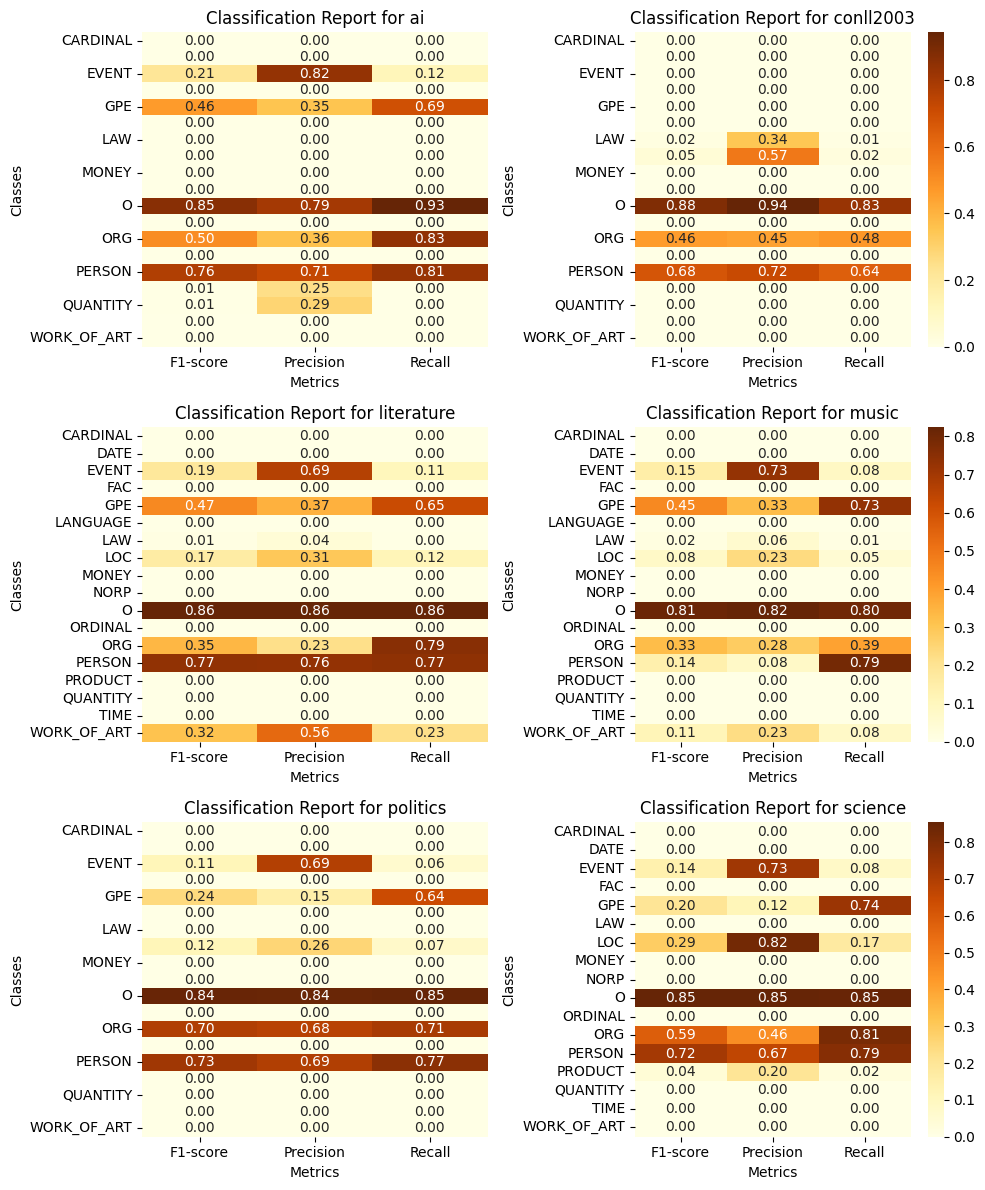

In [135]:
def plot_combined_heatmaps(metrics_df, domains, metrics=["Precision", "Recall", "F1-score"]):
    """
    Строит тепловые карты для каждого домена с Precision, Recall и F1-score в одной таблице.
    """
    # Создаем сетку 3x2
    fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 8 * 3 для ширины, 6 * 2 для высоты
    axes = axes.flatten()  # Преобразуем в 1D массив для удобства итерации

    for idx, domain in enumerate(domains):
        ax = axes[idx]

        # Фильтруем данные для текущего домена
        domain_data = metrics_df[metrics_df["Domain"] == domain]

        # Преобразуем данные для heatmap
        heatmap_data = domain_data.pivot(index="Tag", columns="Metric", values="Value")
        
        # Создаем heatmap
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".2f",
            cmap="YlOrBr",
            cbar=True if idx % 2 == 1 else False,  # Добавляем colorbar только для второго столбца
            ax=ax
        )
        ax.set_title(f"Classification Report for {domain}")
        ax.set_xlabel("Metrics")
        ax.set_ylabel("Classes")
    
    # Отключаем пустые графики, если доменов меньше, чем ячеек
    for idx in range(len(domains), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Подготовка данных
metrics_expanded = pd.melt(
    calculate_metrics_per_domain(annotations, domains),
    id_vars=["Domain", "Tag"],
    value_vars=["Precision", "Recall", "F1-score"],
    var_name="Metric",
    value_name="Value"
)

# Построение тепловых карт
plot_combined_heatmaps(metrics_expanded, domains)
